## First use the HPLC_molecule_creation script if it is the fist analysis load
load the molecules from the path

In [10]:
from chromatopy import ChromAnalyzer
import os
import json
from chromatopy import Molecule

# create list to add molecules to
molecules = []

# define path to the calibration molecules
molecule_path = "data/calib_molecules/"

# loop over all the files in the calibration molecules
for molecule_name in os.listdir("data/calib_molecules/"):
    full_path = os.path.join(molecule_path, molecule_name)

    # read the molecule data and reconstruct the molecule object
    with open(full_path, "r") as f:
        molecule_dict = json.load(f)

        # append the molecule to the list
        molecules.append(Molecule(**molecule_dict))

# If you have a negative control otherwise can skip to time samples 

In [ ]:
timecourse_path = "Data/MjNK/Negative control"

# need to define the initial concentrations of the molecules
# therefore create a dictionary with the molecule ids as key and the initial concentration as value
init_conc = {
    "Ado": 5,
    "ADP": 0,
    "AMP": 0,
    "ATP": 5,
}

# read the timecourse data
analyzer = ChromAnalyzer.read_agilent(
    path=timecourse_path, ph=8, temperature=37, mode="timecourse"
)

# add the calibration molecules to the timecourse data
for molecule in molecules:
    analyzer.add_molecule(
        molecule=molecule,
        init_conc=init_conc[molecule.id],
    )

analyzer.visualize_all(assigned_only=True)

In [ ]:
enzymeml_doc = analyzer.to_enzymeml(
    name="negative control",
)

In [ ]:
import matplotlib.pyplot as plt

for measurement in enzymeml_doc.measurements:
    for molecule in measurement.species_data:
        plt.scatter(molecule.time, molecule.data, label=molecule.species_id)
plt.xlabel("time [min]")
plt.ylabel("Concentration [mM]")
plt.legend()

## Timecourse data analysis 



In [11]:
# first set the path for your time samples each repetition shut be in a separate folder   
all_reps = []
data_path = "data/MjNK/Time sample"
for path in os.listdir(data_path):
        path = os.path.join(data_path, path)
        all_reps.append(path)


# need to define the initial concentrations of the molecules
# therefore create a dictionary with the molecule ids as key and the initial concentration as value
init_conc = {
    "Ado": 5,
    "ADP": 0,
    "AMP": 0,
    "ATP": 5,
}
# read the timecourse data
for i, path in enumerate(all_reps):
    analyzer = ChromAnalyzer.read_agilent(
        path=path, ph=8, temperature=37, mode="timecourse"
    )

    # add the calibration molecules to the timecourse data
    for molecule in molecules:
        analyzer.add_molecule(
            molecule=molecule,
            init_conc=init_conc[molecule.id],
        )

    # in the first iteration, create the enzymeML document
    # concentration calculation is enabled by default
    if i == 0:
        timecourse_enzymeML = analyzer.to_enzymeml(name="timecourse data")

    # in the following iterations, add the data to the enzymeML document
    else:
        analyzer.add_to_enzymeml(timecourse_enzymeML)

 Loaded 8 chromatograms.
🎯 Assigned Adenosine to 8 peaks
🎯 Assigned Adenosine-5'-diphosphate to 8 peaks
🎯 Assigned Adenosine Phosphate to 8 peaks
🎯 Assigned Adenosine Triphosphate to 8 peaks
 Loaded 8 chromatograms.
🎯 Assigned Adenosine to 8 peaks
🎯 Assigned Adenosine-5'-diphosphate to 8 peaks
🎯 Assigned Adenosine Phosphate to 8 peaks
🎯 Assigned Adenosine Triphosphate to 8 peaks
 Loaded 8 chromatograms.
🎯 Assigned Adenosine to 8 peaks
🎯 Assigned Adenosine-5'-diphosphate to 8 peaks
🎯 Assigned Adenosine Phosphate to 8 peaks
🎯 Assigned Adenosine Triphosphate to 8 peaks


## Get means and standard deviations among measurements with identical initial conditions

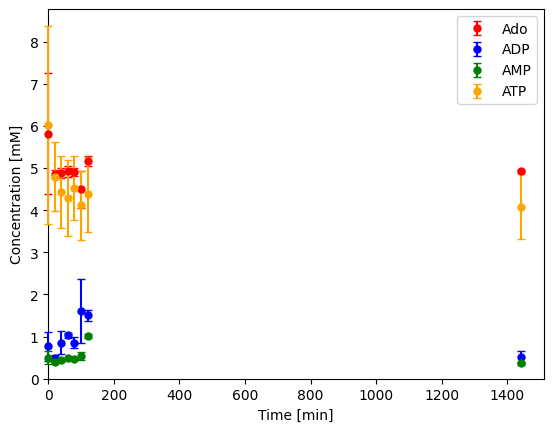

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Define colors for each molecule
colors = {
    "Ado": "red",
    "ADP": "blue",
    "AMP": "green",
    "ATP": "orange",
}

# Initialize a dictionary to store time and data values for each molecule across measurements
molecule_data = {species_id: {"time": [], "data": []} for species_id in colors.keys()}

# Aggregate data for each molecule across all measurements
for measurement in timecourse_enzymeML.measurements:
    for molecule in measurement.species_data:
        molecule_data[molecule.species_id]["time"].append(molecule.time)
        molecule_data[molecule.species_id]["data"].append(molecule.data)

# Plot mean and standard deviation for each molecule
for species_id, data_dict in molecule_data.items():
    # Convert lists of time and data to NumPy arrays for easier computation
    times = np.array(data_dict["time"])
    data_values = np.array(data_dict["data"])

    # Calculate mean and standard deviation along the measurements axis
    mean_time = np.mean(times, axis=0)
    mean_data = np.mean(data_values, axis=0)
    std_data = np.std(data_values, axis=0)

    # Plot mean as scatter points with error bars for standard deviation
    color = colors[species_id]
    plt.errorbar(
        mean_time,
        mean_data,
        yerr=std_data,
        fmt="o",
        color=color,
        label=species_id,
        ecolor=color,
        capsize=3,
        markersize=5,
        alpha=1,
        zorder=5,
        clip_on=False
    )


# Set y-axis to start at zero
plt.ylim(bottom=0)
plt.xlim(left=0)

# Customize and show the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.xlabel("Time [min]")
plt.ylabel("Concentration [mM]")
plt.legend(by_label.values(), by_label.keys())
plt.savefig('data/MjNK/results/Concentration_time_table.png')
plt.show()



In [14]:
# save the enzymeML document to file

with open("timecourse_enzymeML.json", "w") as f:
    f.write(timecourse_enzymeML.model_dump_json())